# 1.2 - Gaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
from typing import Union, List

import numpy as np

from sklearn.datasets import make_moons
from scipy import stats
# Packages
import numpy as np
from sklearn.decomposition import PCA
from picard import Picard
import pytorch_lightning as pl


# Plot
import matplotlib.pyplot as plt
import corner

from tqdm.notebook import trange, tqdm 
import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [3]:
# TODO

## Data

In [4]:
ntrain = 100_000
nvalid = 5_000
ntest = 10_000
nplot = 1_000_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
val_data = make_moons(n_samples=nvalid, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]
plot_data = make_moons(n_samples=nplot, noise=noise, random_state=random_state*10)[0]

In [51]:
def make_checkerboard(n_samples):
    x1 = np.random.rand(n_samples) * 4 - 2
    x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, [n_samples]) * 2
    x2 = x2_ + np.floor(x1) % 2
    data = np.vstack([x1, x2]).T * 2
    return data

In [52]:
train_data = make_checkerboard(n_samples=ntrain,)
val_data = make_checkerboard(n_samples=nvalid, )
test_data = make_checkerboard(n_samples=ntest, )
plot_data = make_checkerboard(n_samples=nplot, )

In [53]:
train_data.shape

(100000, 2)

### Plot Data

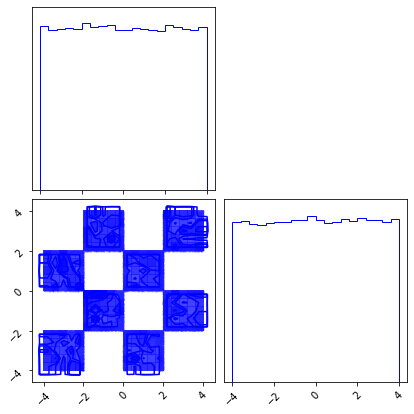

In [54]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

## Flow Transformation

In [55]:
class Bijector:
    
    def forward(self, X):
        raise NotImplemented
        
    def inverse(self, X):
        raise NotImplemented
    
    def gradient(self, X):
        raise NotImplemented
    

### Marginal Uniformization

In [56]:
class MarginalHistogramUniformization:
    name: str= "marghistuni"
 
    
    def __init__(self, X: np.ndarray, bins: Union[int,str]="auto", alpha: float=1e-10, bound_ext: float=0.1):
        
        estimators = []
        
        
        for iX in X.T:
            diff = iX.max() - iX.min()
            lower_bound = iX.min() - bound_ext * diff
            upper_bound = iX.max() + bound_ext * diff

            # create histogram 
            hist = np.histogram(iX, bins=bins, range=(lower_bound, upper_bound))

            # create histogram object
            i_estimator = stats.rv_histogram(hist)

            # add some regularization
            i_estimator._hpdf += alpha
            
            estimators.append(i_estimator)
            
        self.estimators = estimators
        
    def forward(self, X):
        
        Z = np.zeros_like(X)
        for idim, iX in enumerate(X.T):
            Z[:, idim] = self.estimators[idim].cdf(iX)
        
        return Z
    
    def inverse(self, Z):
        
        X = np.zeros_like(Z)
        
        for idim, iZ in enumerate(Z.T):
            
            X[:, idim] = self.estimators[idim].ppf(iZ)
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros_like(X)
        
        for idim, iX in enumerate(X.T):
            X_grad[:, idim] = self.estimators[idim].logpdf(iX)
        X_grad = X_grad.sum(axis=-1)
        return X_grad

### Marginal Uniformization (KDE)

In [57]:
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from typing import NamedTuple

class KDEParams(NamedTuple):
    support : np.ndarray
    pdf_est : np.ndarray
    cdf_est : np.ndarray

class MarginalKDEUniformization:
    name: str= "marghistuni"
 
    
    def __init__(self, X: np.ndarray, grid_size: int=50, n_quantiles:int=50, bound_ext: float=0.1, fft: bool=True):
        
        estimators = []
        
        # estimate bandwidth
        bw = np.power(X.shape[0], -1 / (X.shape[1] + 4.0))
        
        
        for iX in X.T:
            

            # create histogram 
            estimator = sm.nonparametric.KDEUnivariate(iX.squeeze())
            
            estimator.fit(
                    kernel="gau", bw=bw, fft=fft, gridsize=grid_size,
                )
            
            # estimate support
            diff = iX.max() - iX.min()
            lower_bound = iX.min() - bound_ext * diff
            upper_bound = iX.max() + bound_ext * diff
            support = np.linspace(lower_bound, upper_bound, n_quantiles)
            
            # estimate empirical pdf from data
            hpdf = estimator.evaluate(support)
            
            # estimate empirical cdf from data
            hcdf = ECDF(iX)(support)
            
            kde_params = KDEParams(support=support, pdf_est=np.log(hpdf), cdf_est=hcdf)
            estimators.append(kde_params)
            
        self.estimators = estimators
        
    def forward(self, X):
        
        Z = np.zeros_like(X)
        for idim, iX in enumerate(X.T):
            iparams = self.estimators[idim]
            Z[:, idim] = np.interp(iX, xp=iparams.support, fp=iparams.cdf_est)
        
        return Z
    
    def inverse(self, Z):
        
        X = np.zeros_like(Z)
        
        for idim, iZ in enumerate(Z.T):
            
            iparams = self.estimators[idim]
            X[:, idim] = np.interp(iZ, xp=iparams.cdf_est, fp=iparams.support)
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros_like(X)
        
        for idim, iX in enumerate(X.T):
            
            iparams = self.estimators[idim]
            X_grad[:, idim] = np.interp(iX, xp=iparams.support, fp=iparams.pdf_est)
            
        X_grad = X_grad.sum(axis=-1)
        return X_grad

### Sigmoid

In [58]:
from scipy.special import expit, logit

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def stable_sigmoid(x):
    return np.where(x < -9, np.exp(x), sigmoid(x))

def softplus(x):
    return np.log(np.exp(x) + 1)

def stable_softplus(x):
    return np.where(x < -9, np.log1p(np.exp(x)), softplus(x))


class Sigmoid:
    name: str= "gausscdf"
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def inverse(self, X):
        
        Z = np.clip(X, self.eps, 1-self.eps)
        
        Z = np.log(X) - np.log1p(-X)
        
        return Z
        
    def forward(self, Z):
        X = stable_sigmoid(Z)
        
        return X
    
    def gradient(self, X):
        
        X_log_grad = - stable_softplus(-X) - stable_softplus(X)
        
        X_log_grad = X_log_grad.sum(axis=-1)
        
        return X_log_grad
    
    
class Logit:
    name: str= "logit"
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def forward(self, X):
        
        Z = np.clip(X, self.eps, 1-self.eps)
        
        Z = np.log(X) - np.log1p(-X)
        
        return Z
        
    def inverse(self, Z):
        X = stable_sigmoid(Z)
        
        return X
    
    def gradient(self, X):
        
        X_log_grad = - stable_softplus(-X) - stable_softplus(X)
        
        X_log_grad = - X_log_grad.sum(axis=-1)
        
        return X_log_grad

### Gaussian CDF

In [59]:
# _half_log2pi = 0.5 * math.log(2 * math.pi)

class GaussCDF:
    name: str= "gausscdf"
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def inverse(self, X):
        
        Z = np.clip(X, self.eps, 1-self.eps)
        
        Z = self.estimator.ppf(Z)
        
        return Z
        
    def forward(self, Z):
        X = self.estimator.cdf(Z)
        
        return X
    
    def gradient(self, X):
        
        X_log_grad = self.estimator.logpdf(X)
        
        X_log_grad = X_log_grad.sum(axis=-1)
        
        return X_log_grad

### Inverse Gauss CDF

In [60]:

    
class InverseGaussCDF:
    name: str= "invgausscdf"
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def forward(self, X):
        
        Z = np.clip(X, self.eps, 1-self.eps)
        
        Z = self.estimator.ppf(Z)
        
        return Z
        
    def inverse(self, Z):
        X = self.estimator.cdf(Z)
        
        return X
    
    def gradient(self, X):
        Z = self.forward(X)
        
        X_log_grad = -self.estimator.logpdf(Z)
        
        X_log_grad = X_log_grad.sum(axis=-1)
        
        return X_log_grad
        
    

### Composite Bijector

In [61]:

    
class CompositeBijector:
    def __init__(self, bijectors: List[Bijector]):
        self.bijectors = bijectors
        
    def forward(self, X):
        
        Z = X.copy()
        for ibijector in self.bijectors:
            Z = ibijector.forward(Z)
            
        return Z
    
    def inverse(self, Z):
        
        X = Z.copy()
        for ibijector in reversed(self.bijectors):
            X = ibijector.inverse(X)
            
        return X
    
    def gradient(self, X):
        
        Z = X.copy()
        X_grad = np.zeros_like(X).sum(axis=-1)
        for ibijector in self.bijectors:
            X_grad += ibijector.gradient(Z)
            Z = ibijector.forward(Z)
            

            
        return X_grad

In [62]:
gauss_cdf_bijector = Sigmoid()

marg_hist_bijector = MarginalHistogramUniformization(X=train_data, bins="sqrt", bound_ext=0.0)
marg_hist_bijector = MarginalKDEUniformization(X=train_data, bound_ext=0.2)

# invcdf = InverseGaussCDF(eps=1e-5)
invcdf = Logit(1e-10)

bijectors = [gauss_cdf_bijector, marg_hist_bijector, invcdf]

marg_gauss_bijector = CompositeBijector(bijectors)

X_g = marg_gauss_bijector.forward(train_data)
X_ldj = marg_gauss_bijector.gradient(train_data)

In [63]:
t = np.random.rand(10,2)
t.min(), t.max()

(0.002877503652895852, 0.9801801449861391)

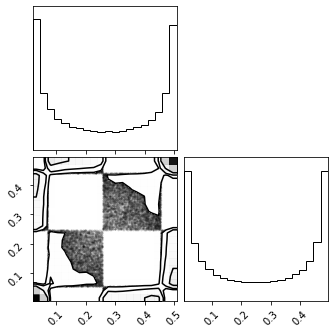

In [64]:
fig = corner.corner(X_g)

## Rotation

### PCA

In [65]:
class PCARotation:
    name: str= "pca"
    def __init__(self, X: np.ndarray, **kwargs):
        
        # create histogram object
        self.estimator = PCA().fit(X)
    
    def forward(self, X):
        
        Z = self.estimator.transform(X)
        
        return Z
        
    def inverse(self, Z):
        X = self.estimator.inverse_transform(Z)
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros(X.shape[0])
        
        return X_grad

### Random Rotations

In [66]:
from picard import Picard

class RandomRotation:
    name: str= "ica"
    def __init__(self, X: np.ndarray,**kwargs):
        
        # create histogram object
        self.rand_ortho_matrix = stats.ortho_group.rvs(X.shape[1])
    
    def forward(self, X):
        
        Z = X @ self.rand_ortho_matrix
        
        return Z
        
    def inverse(self, Z):
        X = Z @ self.rand_ortho_matrix.T
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros(X.shape[0])
        
        return X_grad

In [67]:
pca_bijector = PCARotation(X_g)
randrot_bijector = RandomRotation(X_g)



X_r = randrot_bijector.forward(X_g)

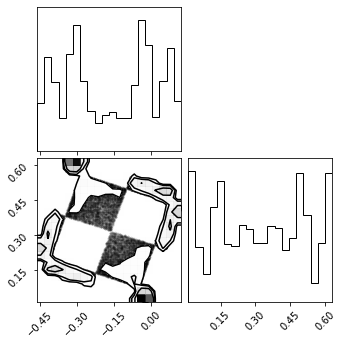

In [68]:
fig = corner.corner(X_r)

In [69]:
# X_g_inv = ica_bijector.forward(X_r)

In [70]:
# fig = corner.corner(X_g_inv)

In [71]:
marg_hist_bijector = MarginalHistogramUniformization(X=train_data)

invcdf = InverseGaussCDF(eps=1e-5)
invcdf = Logit(1e-10)

pca_bijector = RandomRotation(X_g)

bijectors = [gauss_cdf_bijector, marg_hist_bijector, invcdf, pca_bijector]

marg_gauss_bijector = CompositeBijector(bijectors)

X_g = marg_gauss_bijector.forward(train_data)

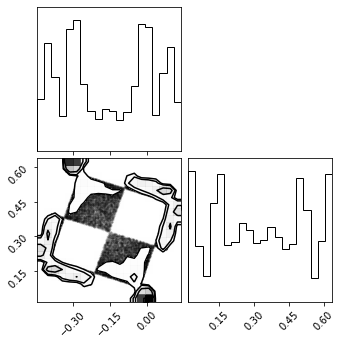

In [72]:
fig = corner.corner(X_g)

## More Transformations

In [73]:
def nll(X, X_ldj):
    pz = stats.norm.logpdf(X).sum(axis=-1)
    log_prob = pz + X_ldj
    return -np.mean(log_prob)


def neg_entropy_normal(data):
    """Function to calculate the marginal negative entropy 
    (negative entropy per dimensions). It uses a histogram
    scheme to initialize the bins and then uses a KDE 
    scheme to approximate a smooth solution.
    
    Parameters
    ----------
    data : array, (samples x dimensions)
    
    Returns
    -------
    neg : array, (dimensions)
    
    """

    n_samples, d_dimensions = data.shape

    # bin estimation
    # TODO: Use function
    n_bins = int(np.ceil(np.sqrt(n_samples)))

    neg = np.zeros(d_dimensions)

    # Loop through dimensions
    for idim in range(d_dimensions):

        # =====================
        # Histogram Estimation
        # =====================

        # Get Histogram
        [hist_counts, bin_edges] = np.histogram(
            a=data[:, idim],
            bins="auto",
            range=(data[:, idim].min(), data[:, idim].max()),
        )

        # calculate bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # get delta between bin centers
        delta = bin_centers[3] - bin_centers[2]

        # Calculate probabilities of normal distribution
        pg = stats.norm.pdf(bin_centers, 0, 1)

        # ==================
        # KDE Function Est.
        # ==================

        # Initialize KDE function with data
        kde_model = stats.gaussian_kde(data[:, idim])

        # Calculate probabilities for each bin
        hx = kde_model.pdf(bin_centers)

        # Calculate probabilities
        px = hx / (hx.sum() * delta)

        # ====================
        # Compare
        # ====================

        # Find the indices greater than zero
        idx = np.where((px > 0) & (pg > 0))

        # calculate the negative entropy
        neg[idim] = delta * (px[idx] * np.log2(px[idx] / pg[idx])).sum()

    return neg

In [90]:
X_train = train_data.copy()
# X_train += 0.1 * np.random.rand(*X_train.shape)
X_valid = val_data.copy()
X_ldj_train = np.zeros(X_train.shape[0])
X_ldj_valid = np.zeros(X_valid.shape[0])

n_layers = 100
alpha = 0.98
transformations = []
train_losses = []
valid_losses = []
with trange(n_layers) as pbar:
    for ilayer in pbar:
    

        # marginal uniformization
        ibijector = MarginalHistogramUniformization(X=X_train, bound_ext=0.3, bins="auto", alpha=1e-10)
#         ibijector = MarginalKDEUniformization(X=X_train, bound_ext=0.3, fft=False, n_quantiles=50, grid_size=100)
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        

        # inverse cdf transformation
        ibijector = InverseGaussCDF(1e-7)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        # rotation
        ibijector = PCARotation(X=X_train)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

#         if (ilayer+1) % 5 == 0:
#             fig = corner.corner(X)
            
        # calculate the loss
        loss_train = nll(X_train, X_ldj_train)
        loss_valid = nll(X_valid, X_ldj_valid)
        k2, p = stats.normaltest(X_valid, axis=None)
        neg_ent = neg_entropy_normal(X_valid)
        

        
        
            
        pbar.set_description(f"Loss (Train): {loss_train:.4f} | Loss (Valid): {loss_valid:.4f} | NormTest: {p:.2e} | KL Normal: {neg_ent.sum():.5f}")
        
        train_losses.append(loss_train)
        valid_losses.append(loss_valid)

        

  0%|          | 0/100 [00:00<?, ?it/s]

In [91]:
k2, p = stats.normaltest(X_valid, axis=None)
neg_ent = neg_entropy_normal(X_valid)
k2, p, neg_ent.sum()

(7.979603382487472, 0.018503383138904865, 0.005431689284432664)

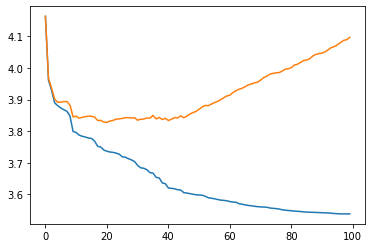

In [92]:
fig, ax = plt.subplots()
ax.plot(train_losses)
ax.plot(valid_losses)
plt.show()

In [93]:
class FlowModel(CompositeBijector):
    def __init__(self, bijectors: List[Bijector], base_dist):
        self.bijectors = bijectors
        self.base_dist = base_dist
        
    def sample(self, n_samples: 10):
        pz_samples = self.base_dist.rvs(size=n_samples)
        
        X = self.inverse(pz_samples)
        return X
    
    def predict_proba(self, X):
        
        # forward tranformation
        Z = self.forward(X)
        
        pz = stats.norm.logpdf(Z).sum(axis=-1)
        
        
        # gradient transformation
        X_ldj = self.gradient(X)
                
        
        
        return np.exp(pz + X_ldj)
    
    def score_samples(self, X, log: bool=True):
        prob = self.predict_proba(X)
        return -np.mean(np.log(prob))

In [94]:
# init base distribution
base_dist = stats.multivariate_normal(mean=np.zeros(2), cov=np.ones(2))

# init flow model
gf_model = FlowModel(transformations, base_dist)

In [95]:
# score test samples
gf_model.score_samples(test_data)

/tmp/ipykernel_225116/1583484769.py:29: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.log(prob))


inf

## Forward Transformation

In [96]:
X_g = gf_model.forward(train_data)

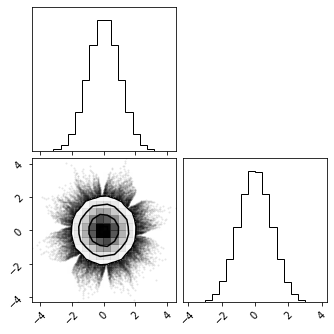

In [97]:
fig = corner.corner(X_g)

### Inverse Transform

In [98]:
X_approx = gf_model.inverse(X_g)

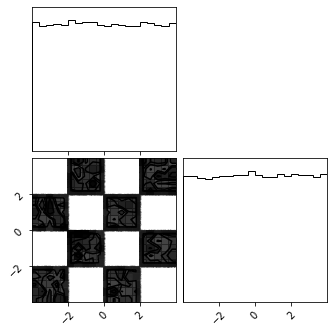

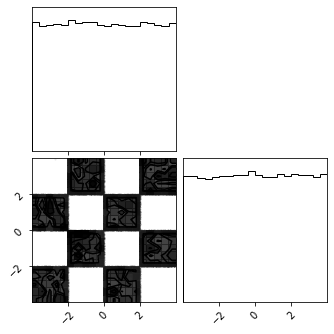

In [99]:
fig = corner.corner(train_data)
fig = corner.corner(X_approx)

## Density Estimation

In [100]:
n_grid = 200
buffer = 0.01
xline = np.linspace(test_data[:, 0].min() - buffer, train_data[:, 0].max() + buffer, n_grid)
yline = np.linspace(test_data[:, 1].min() - buffer, train_data[:, 1].max() + buffer, n_grid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [101]:
X_prob = gf_model.predict_proba(xyinput)

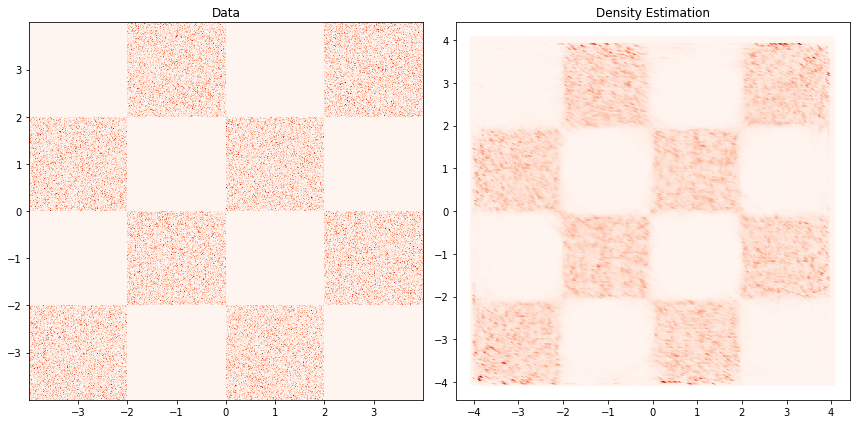

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('Data')
ax[0].hist2d(train_data[...,0], train_data[...,1], cmap="Reds", bins=512, density=True)
# ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Density Estimation')
ax[1].scatter(xyinput[...,0], xyinput[...,1], c=X_prob, cmap="Reds",)
# ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

## Sampling

In [103]:
%%time

X_samples = gf_model.sample(200_000)

CPU times: user 1min 8s, sys: 3.87 s, total: 1min 12s
Wall time: 6.81 s


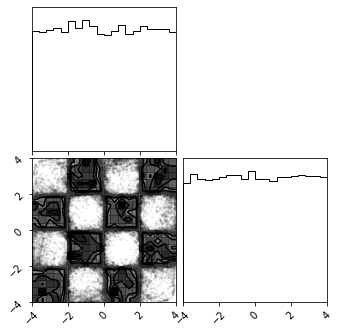

In [104]:
fig = corner.corner(X_samples)